# Canopy Metrics

To Do:
* Mosaic DSM in original CRS
* Mosaic DTM in original CRS
* Subtract DSM and DTM
* Calculate proportion of pixels with canopy over 2m

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import rioxarray as rxr
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge
from pathlib import Path
import pickle

In [8]:
%matplotlib inline

### Mosaic the **DSM**
According to this site, the mosaicing process creates a 16 GB mosaic: https://medium.com/spatial-data-science/how-to-mosaic-merge-raster-data-in-python-fb18e44f3c8  
so instead I used gdalwarp, as follows:

In the command line, run:  
gdalwarp -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER *.tif methow_basin_2018_dsm_origcrs_gdalwarpmosaic_1m.tif  

### Coarsen the DSM to 3m resolution for faster processing

In the command line, run:  
gdalwarp -tr 9.8, 9.8 -r cubic methow_basin_2018_dsm_origcrs_gdalwarpmosaic_1m.tif methow_basin_2018_dsm_origcrs_gdalwarpmosaic_3m.tif -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER
__________________________________________________________________________________________________________________________

### Mosaic the **DTM**

In the command line, run:  
gdalwarp -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER *.tif methow_basin_2018_dtm_origcrs_gdalwarpmosaic_1m.tif

### Coarsen the DTM to 3m resolution for faster processing

In the command line, run:  
gdalwarp -tr 9.8, 9.8 -r cubic methow_basin_2018_dtm_origcrs_gdalwarpmosaic_1m.tif methow_basin_2018_dtm_origcrs_gdalwarpmosaic_3m.tif -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER  
__________________________________________________________________________________________________________________________

### Calculate the **CHM** 

In the command line, run(must have gdal > 3.3):  
gdal_calc.py -A methow/dsm/methow_basin_2018_dsm_origcrs_gdalwarpmosaic_3m.tif -B native_res/methow_basin_2018_dtm_origcrs_combined_3m.tif --outfile=methow_chm_3m.tif --extent=union --calc='A-B' --co COMPRESS=LZW --co TILED=YES --co BIGTIFF=IF_SAFER --overwrite

### Calculate Percent Canopy Cover (CHM pixels > 2m)  
As per Currier et al., 2019: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018WR024533

In [10]:
chm_3m = rxr.open_rasterio('../../data/lidar/methow_chm_3m.tif', masked=True).squeeze()

In [11]:
# convert values from feet to meters
chm_3m_m = chm_3m * 0.304800609601219

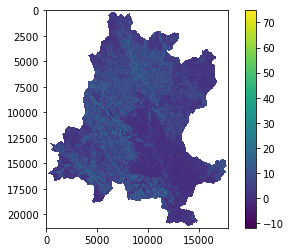

In [12]:
fig, ax = plt.subplots()
c = plt.imshow(chm_3m_m)
plt.colorbar(c)

In [31]:
canopy_pixels_count = (chm_3m_m > 2).sum()
canopy_pixels_count.values

array(87832297)

In [32]:
noncanopy_pixels_count = (chm_3m_m <= 2).sum()
noncanopy_pixels_count.values

array(113256431)

In [37]:
percent_canopy = (canopy_pixels_count.values / (canopy_pixels_count.values + noncanopy_pixels_count.values)) * 100
percent_canopy

43.678379128242334

In [38]:
# Find out how many pixels are masked using code from:
# https://gis.stackexchange.com/questions/382289/count-no-data-pixel-with-rioxarray

valid_px_count = int(chm_3m_m.count().compute())
total_px_count = chm_3m_m.size

nodata_px_count = total_px_count - valid_px_count
nodata_px_count

179206977

### Double check calculations

In [39]:
chm_3m_m.size

380295705

In [40]:
canopy_pixels_count.values + noncanopy_pixels_count.values + nodata_px_count

380295705

Seems to check out!

## Tuolumne Canopy Cover  
Same method as for the Methow, but the CHM already exists (found it on the linux box)

In [63]:
tuol_chm = rxr.open_rasterio('../../data/lidar/tuolumne/USCATB20140827_chm_3p0m_ma.tif', masked=True).squeeze()

In [46]:
tuol_chm_src = rio.open('../../data/lidar/tuolumne/USCATB20140827_chm_3p0m.tif')

In [43]:
tuol_outline = gpd.read_file('../../data/site_outlines/UpperTuolRiverBasinOutline.geojson')

In [ ]:
# with open(out_fp, 'wb') as f:
#     pickle.dump(gm_sntl_depth, f)

# gm_sntl = pickle.load(open(out_fp, 'rb'))

In [58]:
tuol_outline_nolakes = pickle.load(open('../../data/site_outlines/tuol_outline_nolakes.pkl', 'rb'))

In [59]:
tuol_outline_nolakes

,DN,geometry
0,0,GEOMETRYCOLLECTION Z (LINESTRING Z (266480.468...
1,1,GEOMETRYCOLLECTION Z (LINESTRING Z (281303.787...


In [47]:
tuol_outline.to_crs(tuol_chm_src.crs)

,DN,geometry
0,0,"MULTIPOLYGON (((254150.468 4204890.934, 254180..."
1,1,"MULTIPOLYGON (((273170.468 4229640.934, 273260..."


<AxesSubplot:>

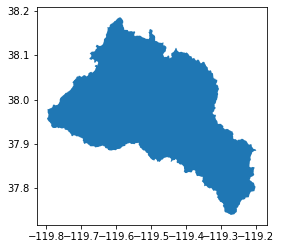

In [50]:
tuol_outline[1:].plot()

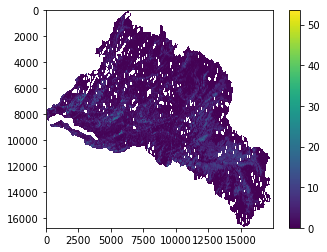

In [64]:
fig, ax = plt.subplots()
c = plt.imshow(tuol_chm)
plt.colorbar(c)

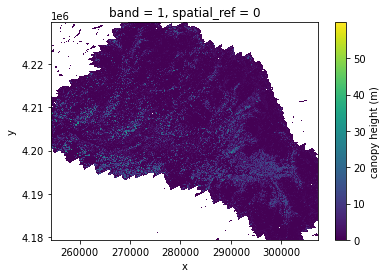

In [53]:
fig, ax = plt.subplots()
tuol_chm.plot()
#tuol_outline[1:].plot(facecolor=None, edgecolor='k')

In [60]:
shape = tuol_outline_nolakes.loc[0, 'geometry']

In [61]:
with rio.open('../../data/lidar/tuolumne/USCATB20140827_chm_3p0m.tif') as src:
    out_image, out_transform = rio.mask.mask(src, shape, crop=True)
    out_meta = src.meta

In [62]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open('../../data/lidar/tuolumne/USCATB20140827_chm_3p0m_ma.tif', "w", **out_meta) as dest:
    dest.write(out_image)

### Calculate Percent Canopy Cover (CHM pixels > 2m)  
As per Currier et al., 2019: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018WR024533

In [65]:
canopy_pixels_count = (tuol_chm > 2).sum()
canopy_pixels_count.values

array(39521235)

In [66]:
noncanopy_pixels_count = (tuol_chm <= 2).sum()
noncanopy_pixels_count.values

array(89537350)

In [67]:
percent_canopy = (canopy_pixels_count.values / (canopy_pixels_count.values + noncanopy_pixels_count.values)) * 100
percent_canopy

30.622709058835568

In [68]:
# Find out how many pixels are masked using code from:
# https://gis.stackexchange.com/questions/382289/count-no-data-pixel-with-rioxarray

valid_px_count = int(tuol_chm.count().compute())
total_px_count = tuol_chm.size

nodata_px_count = total_px_count - valid_px_count
nodata_px_count

163897243

### Double check calculations

In [69]:
tuol_chm.size

292955828

In [70]:
canopy_pixels_count.values + noncanopy_pixels_count.values + nodata_px_count

292955828

Seems to check out!

## Grand Mesa Canopy Cover  

In [72]:
gm_dsm_src = rio.open('../../data/lidar/grandmesa/DSM/gm_20160926_aso_DSM_fromLAZ.tif')

In [73]:
gm_dsm_src.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 35084, 'height': 16652, 'count': 1, 'crs': CRS.from_epsg(32612), 'transform': Affine(1.0, 0.0, 739121.5,
       0.0, -1.0, 4334388.5), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [74]:
gm_dsm_src.crs

CRS.from_epsg(32612)

In [91]:
gm_dtm_src = rio.open('../../data/lidar/grandmesa/snowoff/ASO_3M_PCDTM_USCOGM_20160926_20160926.tif')

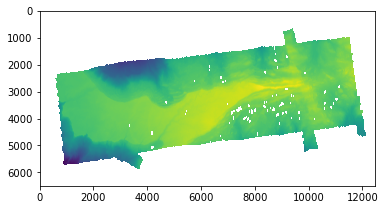

In [94]:
plt.imshow(gm_dtm_src.read(1, masked=True).squeeze())

In [76]:
gm_dtm_src.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 12450, 'height': 6500, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(3.0, 0.0, 218313.0,
       0.0, -3.0, 4336122.0), 'tiled': False, 'interleave': 'band'}

In [77]:
gm_dtm_src.crs

CRS.from_epsg(32613)

### Coarsen the DSM to 3m and Reproject to match DTM  
In the command line run:  
gdalwarp -tr 3, 3 -r cubic -s_srs EPSG:32612 -t_srs EPSG:32613 gm_20160926_aso_DSM_fromLAZ.tif gm_20160926_aso_DSM_fromLAZ_3m.tif -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER

In [87]:
gm_dsm = rxr.open_rasterio('../../data/lidar/grandmesa/DSM/gm_20160926_aso_DSM_fromLAZ_3m.tif', masked=True).squeeze()

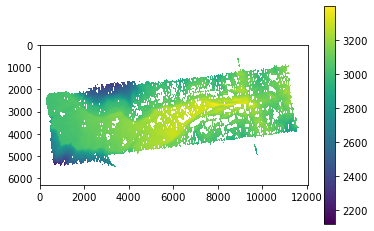

In [88]:
fig, ax = plt.subplots()
c = plt.imshow(gm_dsm)
plt.colorbar(c)

In [89]:
gm_dsm = rxr.open_rasterio('../../data/lidar/grandmesa/DSM/gm_20160926_aso_DSM_fromLAZ.tif', masked=True).squeeze()

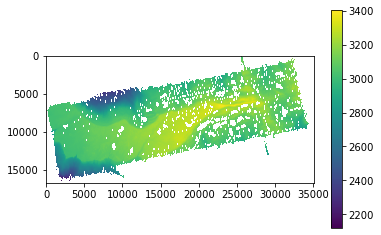

In [90]:
fig, ax = plt.subplots()
c = plt.imshow(gm_dsm)
plt.colorbar(c)

### Calculate the **CHM** 

In the command line, run(must have gdal > 3.3):  
gdal_calc.py -A DSM/gm_20160926_aso_DSM_fromLAZ_3m.tif -B snowoff/ASO_3M_PCDTM_USCOGM_20160926_20160926.tif --outfile=grandmesa_chm_3m.tif --extent=union --calc='A-B' --co COMPRESS=LZW --co TILED=YES --co BIGTIFF=IF_SAFER --overwrite

### Calculate Percent Canopy Cover (CHM pixels > 2m)  
As per Currier et al., 2019: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018WR024533

In [78]:
gm_chm = rxr.open_rasterio('../../data/lidar/grandmesa/grandmesa_chm_3m.tif', masked=True).squeeze()

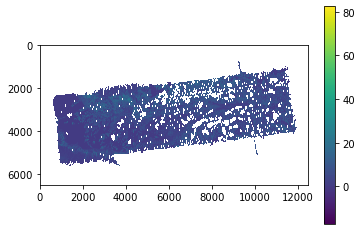

In [79]:
fig, ax = plt.subplots()
c = plt.imshow(gm_chm)
plt.colorbar(c)

In [80]:
canopy_pixels_count = (gm_chm > 2).sum()
canopy_pixels_count.values

array(18728595)

In [81]:
noncanopy_pixels_count = (gm_chm <= 2).sum()
noncanopy_pixels_count.values

array(18365212)

In [82]:
percent_canopy = (canopy_pixels_count.values / (canopy_pixels_count.values + noncanopy_pixels_count.values)) * 100
percent_canopy

50.48981626501696

In [83]:
# Find out how many pixels are masked using code from:
# https://gis.stackexchange.com/questions/382289/count-no-data-pixel-with-rioxarray

valid_px_count = int(gm_chm.count().compute())
total_px_count = gm_chm.size

nodata_px_count = total_px_count - valid_px_count
nodata_px_count

43831193

### Double check calculations

In [84]:
gm_chm.size

80925000

In [85]:
canopy_pixels_count.values + noncanopy_pixels_count.values + nodata_px_count

80925000

Seems to check out!

### Eco Zone Assessment

In [23]:
ecozone = gpd.read_file('../../data/site_outlines/wwf_terr_ecos/wwf_terr_ecos.shp')
tuol_outline = gpd.read_file('../../data/site_outlines/UpperTuolRiverBasinOutline.geojson')
methow_outline = gpd.read_file('../../data/site_outlines/methow_outline.geojson')
gm_outline = gpd.read_file('../../data/site_outlines/gm_outline.geojson')

In [19]:
pd.set_option('display.max_columns', None)

In [20]:
ecozone.head()

,OBJECTID,AREA,PERIMETER,ECO_NAME,REALM,BIOME,ECO_NUM,ECO_ID,ECO_SYM,GBL_STAT,G200_REGIO,G200_NUM,G200_BIOME,G200_STAT,Shape_Leng,Shape_Area,area_km2,eco_code,PER_area,PER_area_1,PER_area_2,geometry
0,1,29.802942,0.219,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,None,0.0,0.0,0.0,0.219475,0.002769,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-112.26972 29.32648, -112.28809 29.3..."
1,2,11.977824,0.193,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,None,0.0,0.0,0.0,0.193289,0.001111,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-112.19907 29.17528, -112.20740 29.1..."
2,3,77301.372760,111.954,Sinaloan dry forests,NT,2.0,28.0,60228.0,98.0,1.0,Southern Mexican Dry Forests,56.0,2.0,1.0,111.951414,6.879188,77362,NT0228,0.0,0.0,0.0,"POLYGON ((-109.11700 27.74142, -109.11228 27.7..."
3,4,215.489182,1.274,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,None,0.0,0.0,0.0,1.273654,0.019701,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-110.54179 27.38383, -110.54462 27.3..."
4,5,19.639089,0.363,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,None,0.0,0.0,0.0,0.363068,0.001791,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-110.52850 27.28641, -110.53336 27.2..."


<AxesSubplot:>

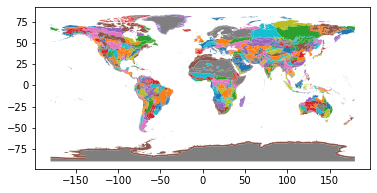

In [13]:
ecozone.plot(column='ECO_NAME')

In [21]:
ecozone.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
tuol_outline.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
ecozone_clipped = gpd.overlay(tuol_outline, ecozone, how='intersection')

In [27]:
ecozone_clipped

,DN,OBJECTID,AREA,PERIMETER,ECO_NAME,REALM,BIOME,ECO_NUM,ECO_ID,ECO_SYM,GBL_STAT,G200_REGIO,G200_NUM,G200_BIOME,G200_STAT,Shape_Leng,Shape_Area,area_km2,eco_code,PER_area,PER_area_1,PER_area_2,geometry
0,0,7537,336212.305609,56.850,Great Basin shrub steppe,NA,13.0,5.0,51305.0,113.0,3.0,None,0.0,0.0,0.0,56.849343,35.357340,336212,NA1305,0.0,0.0,0.0,"MULTIPOLYGON (((-119.20354 37.88830, -119.2035..."
1,1,7537,336212.305609,56.850,Great Basin shrub steppe,NA,13.0,5.0,51305.0,113.0,3.0,None,0.0,0.0,0.0,56.849343,35.357340,336212,NA1305,0.0,0.0,0.0,"MULTIPOLYGON (((-119.20354 37.88830, -119.2035..."
2,0,7643,52871.565674,16.881,Sierra Nevada forests,NA,5.0,27.0,50527.0,70.0,1.0,Sierra Nevada Coniferous Forests,74.0,5.0,1.0,16.880482,5.467816,52872,NA0527,0.0,0.0,0.0,"POLYGON ((-119.79800 37.95838, -119.79801 37.9..."
3,1,7643,52871.565674,16.881,Sierra Nevada forests,NA,5.0,27.0,50527.0,70.0,1.0,Sierra Nevada Coniferous Forests,74.0,5.0,1.0,16.880482,5.467816,52872,NA0527,0.0,0.0,0.0,"POLYGON ((-119.58888 38.18618, -119.58887 38.1..."


<AxesSubplot:>

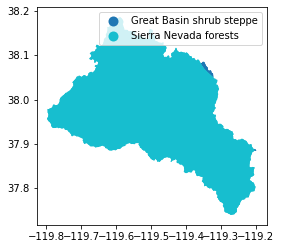

In [31]:
ecozone_clipped.plot(column='ECO_NAME', legend=True)


In [32]:
methow_outline.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [33]:
ecozone_methow = gpd.overlay(methow_outline, ecozone, how='intersection')

<AxesSubplot:>

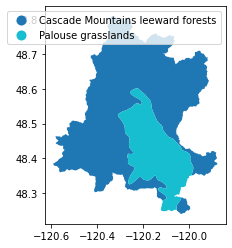

In [34]:
ecozone_methow.plot(column='ECO_NAME', legend=True)

In [36]:
gm_outline = gm_outline.to_crs(ecozone.crs)

In [37]:
ecozone_gm = gpd.overlay(gm_outline, ecozone, how='intersection')

<AxesSubplot:>

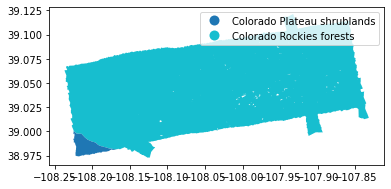

In [39]:
ecozone_gm.plot(column='ECO_NAME', legend=True)